## Accuracy Results
#### Case1:
- d = 4 pixels
- angle np.pi/2
- Results:
    - knn: 0.8205128205128205
    - svm: 0.8717948717948718
    - random forest: 0.9358974358974359

#### Case2:
- d = 4 pixels
- angle 0
- Results:
    - knn: 0.9743589743589743
    - svm: 0.9615384615384616
    - random forest: 0.9487179487179487


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
import glob
import utilities as util
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage import exposure


Females handwritten samples


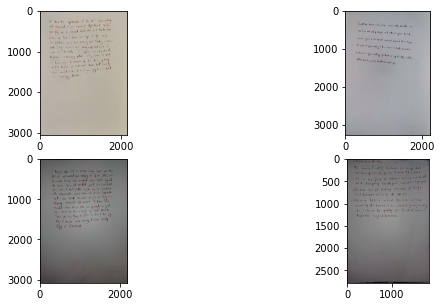

Males handwritten samples


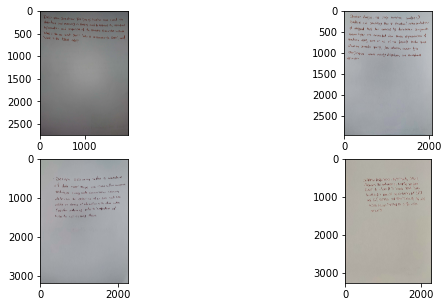

In [2]:
# Read the test images
female_imgs = util.read_imgs('data/Female/Female')
male_imgs = util.read_imgs('data/Male/Male')

# Preview 9 samples
print('Females handwritten samples')
util.draw_grid(figsize=(10,5), rows=2, cols=2, imgs=female_imgs[:4])
print('Males handwritten samples')
util.draw_grid(figsize=(10,5), rows=2, cols=2, imgs=male_imgs[:4])

In [3]:
from skimage.feature import greycomatrix, greycoprops

img = (rgb2gray(female_imgs[10])*255).astype(np.uint8)
glcm = greycomatrix(img, [2], [np.pi/2], levels=255,
                  normed=True, symmetric=True)
contrast = greycoprops(glcm, 'contrast')
dissimilarity = greycoprops(glcm, 'dissimilarity')
homogeneity = greycoprops(glcm, 'homogeneity')
ASM = greycoprops(glcm, 'ASM')
energy = greycoprops(glcm, 'energy')
correlation = greycoprops(glcm, 'correlation')

print(contrast)
print('---------')
print(dissimilarity)
print('---------')
print(homogeneity)
print('---------')
print(ASM)
print('---------')
print(energy)
print('---------')
print(correlation)
print('---------')


[[67.94329802]]
---------
[[2.37259378]]
---------
[[0.65674399]]
---------
[[0.03114862]]
---------
[[0.17648972]]
---------
[[0.87799407]]
---------


In [4]:
# Binary Thresholding and Text Area Extraction on all images
females_count = len(female_imgs) 
males_count = len(male_imgs)

X = []
y = []
# Calculating features for females' images
for i in range(females_count):
    
    img = (rgb2gray(female_imgs[i])*255).astype(np.uint8)
    
#     # Resize the image to reduce the hog feature vector size
#     img = resize(img, (128,64),anti_aliasing=True)
    # Extract glcm features
    glcm = greycomatrix(img, [2], [np.pi/2], levels=255,
                  normed=True, symmetric=True)
    contrast = greycoprops(glcm, 'contrast')[0][0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0][0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0][0]
    ASM = greycoprops(glcm, 'ASM')[0][0]
    energy = greycoprops(glcm, 'energy')[0][0]
    correlation = greycoprops(glcm, 'correlation')[0][0]
    
    glcm_features = [contrast, dissimilarity, homogeneity, ASM, energy, correlation]
    X.append(glcm_features)
    y.append(1)
    
# Calculating features for males' images
for i in range(males_count):
    img = (rgb2gray(male_imgs[i])*255).astype(np.uint8)
    
#     # Resize the image to reduce the hog feature vector size
#     img = resize(img, (128,64),anti_aliasing=True)
    # Extract glcm features
    glcm = greycomatrix(img, [4], [0], levels=255,
                  normed=True, symmetric=True)
    contrast = greycoprops(glcm, 'contrast')[0][0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0][0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0][0]
    ASM = greycoprops(glcm, 'ASM')[0][0]
    energy = greycoprops(glcm, 'energy')[0][0]
    correlation = greycoprops(glcm, 'correlation')[0][0]
    
    glcm_features = [contrast, dissimilarity, homogeneity, ASM, energy, correlation] 
    X.append(glcm_features)
    y.append(0)
    

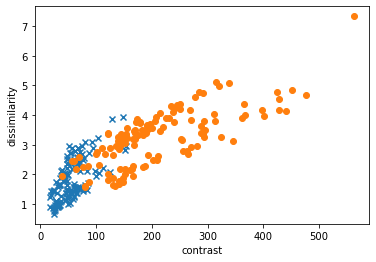

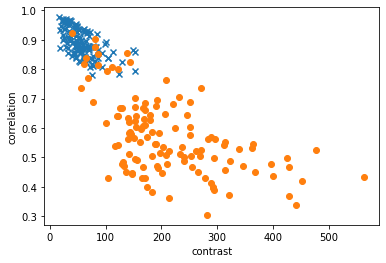

In [5]:
df = pd.DataFrame(X, columns = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation'])
df['gender'] = y
df.head()

male_mask = df['gender'] == 0
female_mask = df['gender'] == 1


plt.scatter(df[female_mask]['contrast'], df[female_mask]['dissimilarity'], marker = "x")
plt.scatter(df[male_mask]['contrast'], df[male_mask]['dissimilarity'], marker = "o")
plt.xlabel('contrast')
plt.ylabel('dissimilarity')
plt.show()

plt.scatter(df[female_mask]['contrast'], df[female_mask]['correlation'], marker = "x")
plt.scatter(df[male_mask]['contrast'], df[male_mask]['correlation'], marker = "o")
plt.xlabel('contrast')
plt.ylabel('correlation')
plt.show()

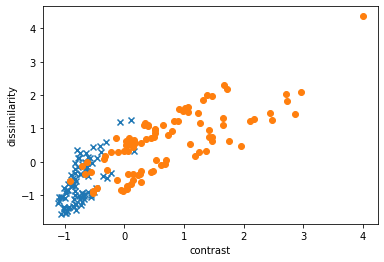

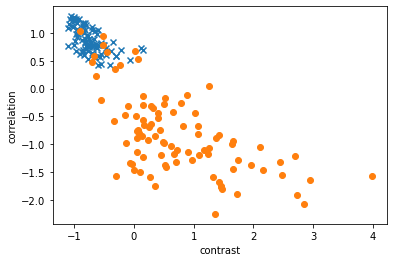

In [7]:
# performing preprocessing part
# Standardize features by removing the mean and scaling to unit variance 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Spliting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) 
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Plotting features accorss each other after standard scalling
female_mask = y_train == 1
male_mask = y_train == 0

plt.scatter(X_train[female_mask][:,0], X_train[female_mask][:,1], marker = "x")
plt.scatter(X_train[male_mask][:,0], X_train[male_mask][:,1], marker = "o")
plt.xlabel('contrast')
plt.ylabel('dissimilarity')
plt.show()

plt.scatter(X_train[female_mask][:,0], X_train[female_mask][:,-1], marker = "x")
plt.scatter(X_train[male_mask][:,0], X_train[male_mask][:,-1], marker = "o")
plt.xlabel('contrast')
plt.ylabel('correlation')
plt.show()

In [8]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.49588607 0.41253951]


In [13]:
from sklearn import svm

clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9615384615384616


In [10]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9487179487179487


In [11]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(X_train,y_train)

#Predict Output
y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9743589743589743
